# Notebook for testing the behavior of the Pikebot model

### Imports

In [1]:
import os
import sys
import io
from io import BytesIO

from tqdm import tqdm

import subprocess
import cairosvg

import chess.svg
from IPython.display import SVG, display

import chess
import chess.pgn
import chess.engine
import numpy as np
import pandas as pd

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

from utils.utils import *
from utils import chess_utils
from utils.pikeBot_chess_utils import Pikebot, PikeBotModelWrapper
from evaluation_utils import *

config=get_paths()

### Paths

In [2]:
model_path = config['pikebotDefault']
maia_path=config['maia_path_cpu']
stockfish_path = config['stockfish_path']
preprocessing_parameters_path = config['preprocessing_params_path']

In [3]:
pgn_file = "../data/lichess_db_standard_rated_2024-03.pgn"

### Load data

In [4]:
with open(pgn_file, 'r') as file:
    # Read all games into memory
    games = []
    while True:
        game = chess.pgn.read_game(file)
        if game is None:
            break
        games.append(game)
    
    games = pd.DataFrame(games, columns=['game'])

games.head()

,game
0,"[Event ""Rated Bullet game""]\n[Site ""https://li..."
1,"[Event ""Rated Bullet game""]\n[Site ""https://li..."
2,"[Event ""Rated Bullet game""]\n[Site ""https://li..."
3,"[Event ""Rated Bullet game""]\n[Site ""https://li..."
4,"[Event ""Rated Bullet game""]\n[Site ""https://li..."


In [5]:
games.shape

(10000, 1)

In [6]:
games.iloc[0].game

<Game at 0x1da53c78be0 ('Parteset' vs. 'ReneSeguel', '2024.03.01' at 'https://lichess.org/DW2E2sO9')>

### Load engines

In [7]:
def get_maia_path(maia_elo):
    version=int(str(maia_elo)[1])
    if version not in [1,5,9]:
        raise ValueError("Maia elo must be from (1100, 1500, 1900)")
    else:
        return maia_path.format(version=version)

class MaiaChess(chess_utils.Player):
    def __init__(self, maia_path: str) -> None:
        super().__init__()
        #redirect error stderr not to display messages from the engine
        self.engine = chess.engine.SimpleEngine.popen_uci(maia_path, stderr=subprocess.DEVNULL)

    def get_best_move(self, board):
        result = self.engine.play(board, chess.engine.Limit(nodes=1))
        move = result.move
        return move

In [8]:
from Pikebot.PikeBotHeuristic8 import PikeBotHeuristic8

stockfish = chess.engine.SimpleEngine.popen_uci(stockfish_path)

model = PikeBotModelWrapper(model_path, preprocessing_parameters_path)
pikebot = Pikebot(
    model,
    chess_utils.max_aggr,
    stockfish_path
)

pikebot_heuristic = PikeBotHeuristic8(
    model,
    chess_utils.max_aggr,
    stockfish_path
)

maias = []
# for e in [1100, 1500, 1900]:
#     maia_path = get_maia_path(e)
#     maias.append(MaiaChess(maia_path))
maia_elo = 1100
maia_path = get_maia_path(maia_elo)
maia = MaiaChess(maia_path)

c:\Users\barte\Desktop\Studies\chess_bot\PikeBot\utils\pikeBot_chess_utils.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model = torch.load(model_path)


## Collect evaluations

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

elos = [800, 1100, 1500, 1900, 2200, 2600]
columns = ['game_id', 'player_elo', 'move_color', 'board_fen', 'player_move', 'maia_move_1100', 'stockfish_move', 'pikebot_heuristic_move'] + \
    [f'pikebot_move_{elo}' for elo in elos] + [f'pikebot_prob_{elo}' for elo in elos]
df_results = pd.DataFrame(columns=columns)

for id, row in tqdm(games.iterrows()):
    game = row.game
    player_elo = int(game.headers["WhiteElo"])
    
    pikebot.reset()
    pikebot_heuristic.reset()

    pikebot.color = chess.WHITE
    pikebot_heuristic.color = chess.WHITE

    move_count = 0
    for x in game.root().mainline():
        move_count += 1

        # Eval only every white move
        if move_count < 8 or x.next() is None or move_count % 2 != 0:
            pikebot.move_history.append(x.board().copy())
            pikebot_heuristic.move_history.append(x.board().copy())
            
            score = pikebot.get_board_score(x.board())

            pikebot.evaluation_history.append(score)
            pikebot_heuristic.evaluation_history.append(score)
            continue
        
        player_move = x.next().move
        info = stockfish.analyse(x.board(), chess.engine.Limit(time=0.1))
        stockfish_move = info['pv'][0]

        maia_move = maia.get_best_move(x.board())

        pikebot_heuristic_move, _ = pikebot_heuristic.induce_own_move(x.board())

        score = info["score"].pov(chess.WHITE)
            
        position_predictions = list()
        prediction_probability = list()
        for elo in elos:
            choice_probs = get_probabilities(pikebot, elo, x.board(), model)
            legal_moves = [move for move in x.board().legal_moves]
            maxid = np.argmax(choice_probs)

            pikebot_move = legal_moves[maxid]
            position_predictions.append(pikebot_move)
            prediction_probability.append(choice_probs[maxid])

        # print(player_move, stockfish_move, position_predictions)
        row = {
            'game_id': id, 
            'player_elo': player_elo,
            'move_color': chess.WHITE,
            'board_fen': x.board().fen(),
            'player_move': player_move,
            'maia_move_1100': maia_move,
            'stockfish_move': stockfish_move,
            'pikebot_heuristic_move': pikebot_heuristic_move,
            **{f'pikebot_move_{elos[i]}': move for i, move in enumerate(position_predictions)},
            **{f'pikebot_prob_{elos[i]}': prob for i, prob in enumerate(prediction_probability)},
        }
        df_results = pd.concat([df_results, pd.DataFrame([row])], ignore_index=True)

        pikebot.move_history.append(x.board().copy())
        pikebot.evaluation_history.append(score.score(mate_score=900))

    # Limit to 10 games
    if id >= 10:
        break

0it [00:00, ?it/s]C:\Users\barte\AppData\Local\Temp\ipykernel_16960\3630833100.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, pd.DataFrame([row])], ignore_index=True)
10it [04:12, 25.30s/it]


In [10]:
df_results.head()

,game_id,player_elo,move_color,board_fen,player_move,maia_move_1100,stockfish_move,pikebot_heuristic_move,pikebot_move_800,pikebot_move_1100,pikebot_move_1500,pikebot_move_1900,pikebot_move_2200,pikebot_move_2600,pikebot_prob_800,pikebot_prob_1100,pikebot_prob_1500,pikebot_prob_1900,pikebot_prob_2200,pikebot_prob_2600
0,0,1514,True,rnbqkbnr/pp3ppp/4p3/3pP3/3p4/2P5/PP3PPP/RNBQKB...,c3d4,c3d4,c3d4,c3d4,f1d3,f1d3,f1d3,f1d3,f1d3,f1d3,0.752002,0.768089,0.785385,0.810482,0.824778,0.841380
1,0,1514,True,r1bqkbnr/pp3ppp/2n1p3/3pP3/3P4/8/PP3PPP/RNBQKB...,g1f3,g1f3,b1c3,g1f3,c1g5,c1g5,c1g5,c1g5,c1g5,c1g5,0.980289,0.976742,0.970429,0.962462,0.954269,0.943010
2,0,1514,True,r1b1kbnr/pp3ppp/1qn1p3/3pP3/3P4/5N2/PP3PPP/RNB...,a2a3,b1c3,b1c3,b1c3,b1d2,b1d2,b1d2,b1d2,b1d2,b1d2,0.814511,0.823847,0.829468,0.842873,0.848959,0.857709
3,0,1514,True,r3kbnr/pp1b1ppp/1qn1p3/3pP3/3P4/P4N2/1P3PPP/RN...,b2b4,b1c3,b1c3,b1c3,f1e2,f1e2,f1e2,f1e2,f1e2,f1e2,0.795466,0.807998,0.821397,0.834981,0.846501,0.854866
4,0,1514,True,r3kbnr/1p1b1ppp/1qn1p3/p2pP3/1P1P4/P4N2/5PPP/R...,b4b5,b4b5,b4b5,b4b5,f1e2,f1e2,f1e2,f1e2,f1e2,f1e2,0.785012,0.797171,0.801957,0.809627,0.811589,0.814222


In [11]:
df_results.shape

(339, 20)

In [12]:
# df_results['game_id'].value_counts()

In [13]:
df_results.to_csv('../data/evaluation_results_games1-10.csv', index=False)

### Visualization function

In [14]:
def compare_moves(row, heuristic, size=300):
    """
    Displays multiple chess boards next to each other in one row.

    :param row: DataFrame row.
    :param size: The size of each board in pixels (default is 300).
    """
    elos = [800, 1100, 1500, 1900, 2200, 2600]

    # Create a list of boards
    board = chess.Board(row['board_fen'])
    boards = [chess.svg.board(board.copy(), size=size)]
    board.push(row['player_move'])
    boards.append(chess.svg.board(board.copy(), size=size, lastmove=row['player_move']))
    board.pop()
    
    board.push(row[f'maia_move_1100'])
    boards.append(chess.svg.board(board.copy(), size=size, lastmove=row[f'maia_move_1100']))
    board.pop()

    board.push(row['stockfish_move'])
    boards.append(chess.svg.board(board.copy(), size=size, lastmove=row['stockfish_move']))
    board.pop()
    board.push(row['pikebot_heuristic_move'])
    boards.append(chess.svg.board(board.copy(), size=size, lastmove=row['pikebot_heuristic_move']))
    board.pop()

    titles = ["Board", f"Player (elo {row['player_elo']})", "Maia 1100", "Stockfish", f"Pikebot Heur. {heuristic}", ]

    for e in elos:
        board.push(row[f'pikebot_move_{e}'])
        titles.append(f"Pikebot {e}")
        boards.append(chess.svg.board(board.copy(), size=size, lastmove=row[f'pikebot_move_{e}']))
        board.pop()
    
    # Create a figure with one row and as many columns as there are boards
    fig, axes = plt.subplots(2, 5, figsize=(5 * size / 100, 2 * size / 100 + 1))
    axes = axes.flatten()
    
    # Generate and display each board
    for ax, board_svg, title in zip(axes, boards, titles):
        # Generate the SVG and convert to PNG
        png_image = cairosvg.svg2png(bytestring=board_svg)
        
        # Load the PNG into Matplotlib
        img = plt.imread(BytesIO(png_image), format='png')
        ax.imshow(img)
        ax.axis('off')  # Remove axes
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

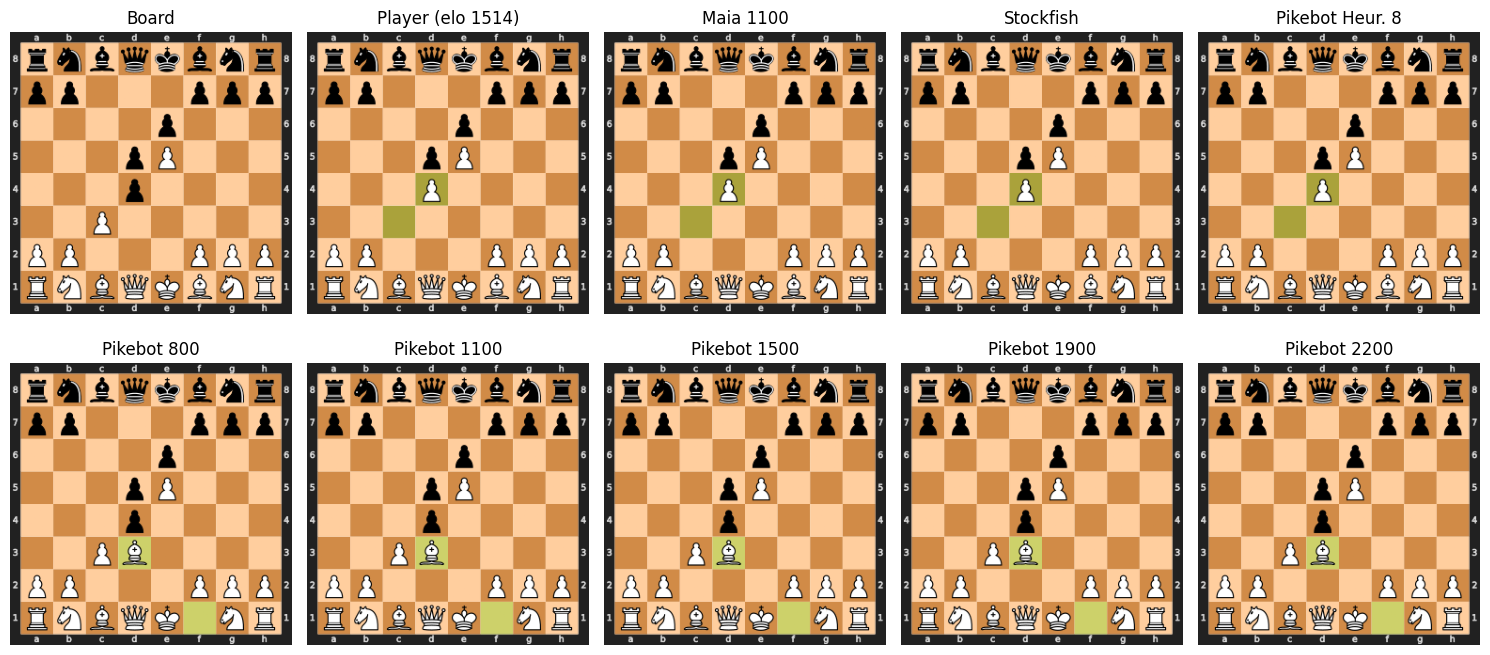

In [15]:
compare_moves(df_results.iloc[0], 8)

## Analysis

In [16]:
# Only one maia will be used since all results are the same for 2455 moves tested
# print(f'Human vs stockfish matches: {(((df_results["maia_move_1100"] == df_results["maia_move_1500"]) & (df_results["maia_move_1500"] == df_results["maia_move_1900"]))).sum()}')

In [17]:
print("=== Number of matched moves ====")

print(f'- Human and stockfish: {(df_results["player_move"] == df_results["stockfish_move"]).sum()}')
print(f'- Human and Maia: {(df_results["player_move"] == df_results["maia_move_1100"]).sum()}')
print(f'- Stockfish and Maia: {(df_results["stockfish_move"] == df_results["maia_move_1100"]).sum()}')

print()
print("Pikebots:")
print(f'- Human and Pikebot Heuristic: {(df_results["player_move"] == df_results["pikebot_heuristic_move"]).sum()}')
print(f"- Stockfish and Pikebot Heuristic: {(df_results['stockfish_move'] == df_results[f'pikebot_heuristic_move']).sum()}")
for elo in elos:
    print(elo)
    print(f"- Human and Pikebot: {(df_results['player_move'] == df_results[f'pikebot_move_{elo}']).sum()}")
    print(f"- Stockfish and Pikebot: {(df_results['stockfish_move'] == df_results[f'pikebot_move_{elo}']).sum()}")

=== Number of matched moves ====
- Human and stockfish: 127
- Human and Maia: 162
- Stockfish and Maia: 144

Pikebots:
- Human and Pikebot Heuristic: 109
- Stockfish and Pikebot Heuristic: 168
800
- Human and Pikebot: 57
- Stockfish and Pikebot: 64
1100
- Human and Pikebot: 57
- Stockfish and Pikebot: 61
1500
- Human and Pikebot: 60
- Stockfish and Pikebot: 72
1900
- Human and Pikebot: 66
- Stockfish and Pikebot: 81
2200
- Human and Pikebot: 69
- Stockfish and Pikebot: 81
2600
- Human and Pikebot: 77
- Stockfish and Pikebot: 93


In [18]:
stockfish_different_matches = []
for elo in elos:
    print(f'Human and Pikebot {elo} not Stockfish matches: {((df_results["player_move"] == df_results[f"pikebot_move_{elo}"]) & (df_results["player_move"] != df_results["stockfish_move"])).sum()}')
    stockfish_different_matches.append((elo, df_results[((df_results["player_move"] == df_results[f"pikebot_move_{elo}"]) & (df_results["player_move"] != df_results["stockfish_move"]))].index))

Human and Pikebot 800 not Stockfish matches: 29
Human and Pikebot 1100 not Stockfish matches: 29
Human and Pikebot 1500 not Stockfish matches: 29
Human and Pikebot 1900 not Stockfish matches: 27
Human and Pikebot 2200 not Stockfish matches: 30
Human and Pikebot 2600 not Stockfish matches: 33


In [19]:
maia_different_matches = []
for elo in elos:
    print(f'Human and Pikebot {elo} not Maia matches: {((df_results["player_move"] == df_results[f"pikebot_move_{elo}"]) & (df_results["player_move"] != df_results["maia_move_1100"])).sum()}')
    maia_different_matches.append((elo, df_results[((df_results["player_move"] == df_results[f"pikebot_move_{elo}"]) & (df_results["player_move"] != df_results["maia_move_1100"]))].index))

Human and Pikebot 800 not Maia matches: 25
Human and Pikebot 1100 not Maia matches: 24
Human and Pikebot 1500 not Maia matches: 24
Human and Pikebot 1900 not Maia matches: 23
Human and Pikebot 2200 not Maia matches: 25
Human and Pikebot 2600 not Maia matches: 29


In [20]:
maia_stockfish_different_matches = []
for elo in elos:
    mask = ((df_results["player_move"] == df_results[f"pikebot_move_{elo}"]) &
            (df_results["player_move"] != df_results["maia_move_1100"]) &
            (df_results["player_move"] != df_results["stockfish_move"]))
    print(f'Human and Pikebot {elo} not Maia and not Stockfish matches: {(mask).sum()}')
    maia_stockfish_different_matches.append((elo, df_results[mask].index))

Human and Pikebot 800 not Maia and not Stockfish matches: 18
Human and Pikebot 1100 not Maia and not Stockfish matches: 17
Human and Pikebot 1500 not Maia and not Stockfish matches: 17
Human and Pikebot 1900 not Maia and not Stockfish matches: 16
Human and Pikebot 2200 not Maia and not Stockfish matches: 18
Human and Pikebot 2600 not Maia and not Stockfish matches: 20


In [21]:
mask = ((df_results["player_move"] == df_results[f"pikebot_heuristic_move"]) &
        (df_results["player_move"] != df_results["maia_move_1100"]) &
        (df_results["player_move"] != df_results["stockfish_move"]))
print(f'Human and Pikebot Heuristic not Maia and not Stockfish matches: {(mask).sum()}')
maia_stockfish_different_matches_heuristic = (elo, df_results[mask].index)

Human and Pikebot Heuristic not Maia and not Stockfish matches: 18


In [29]:
maia_stockfish_different_matches[-1]

(2600,
 Index([ 32,  41,  61,  87,  95, 100, 139, 152, 162, 165, 177, 210, 216, 239,
        247, 251, 252, 304, 322, 338],
       dtype='int64'))

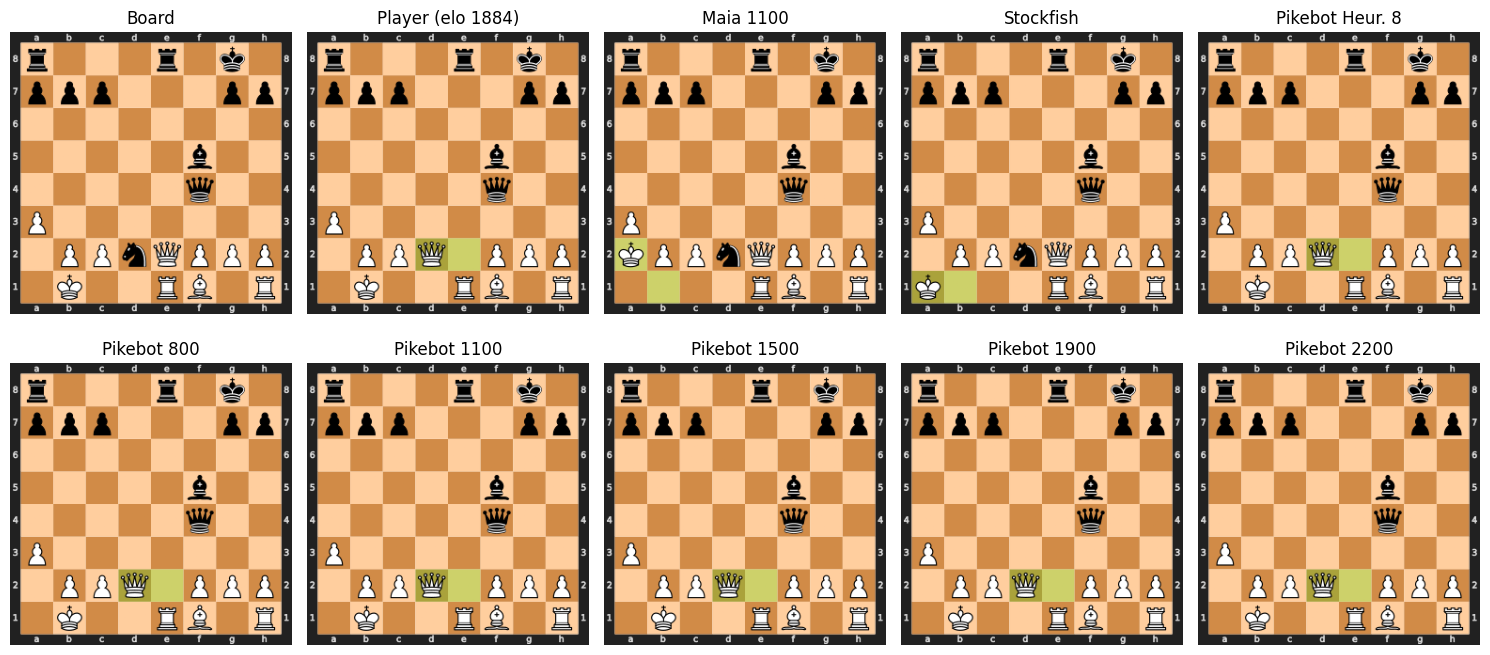

In [33]:
compare_moves(df_results.iloc[252], 8)

## Other

In [81]:
maiachess_fen = '2k1r1r1/2qb4/p3pB1p/nPPpPnp1/8/2P2N2/2Q1BPPP/R4RK1 w - - 0 1'

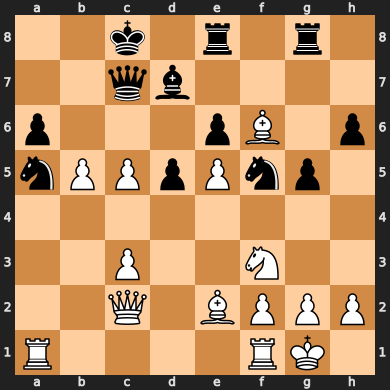

In [82]:
board = chess.Board(maiachess_fen)
board

In [83]:
info = stockfish.analyse(board, chess.engine.Limit(time=0.1))
info["score"].pov(color=chess.WHITE).score(mate_score=900)

591

In [84]:
result = stockfish.play(board, chess.engine.Limit(time=0.1), info=2)
result.move, result.info["score"]

(Move.from_uci('c5c6'), PovScore(Cp(+602), WHITE))

In [92]:
model = PikeBotModelWrapper(model_path, preprocessing_parameters_path)
pikebot = Pikebot(
    model,
    chess_utils.max_aggr,
    stockfish_path,
    color="white",
    time_limit=0.01,
    opponents_elo=200
)

In [93]:
pikebot.get_best_move(board)

Move.from_uci('c2d1')

In [ ]:
# def compare_moves_min(row, size=300):
#     """
#     Displays multiple chess boards next to each other in one row.

#     :param row: DataFrame row.
#     :param size: The size of each board in pixels (default is 300).
#     """
#     elos = [800, 1100, 1400, 1700, 2000, 2300, 2600]

#     # Create a list of boards
#     board = chess.Board(row['board_fen'])
#     boards = [board.copy()]
#     board.push(row['player_move'])
#     boards.append(board.copy())
#     board.pop()
#     board.push(row['stockfish_move'])
#     boards.append(board.copy())
#     board.pop()

#     player_elo = row['player_elo']
#     closest_elo_pikebot_move = min(elos, key=lambda elo: abs(elo - player_elo))
#     board.push(row[f'pikebot_move_{closest_elo_pikebot_move}'])
#     boards.append(board.copy())
#     board.pop()

#     # Number of boards to display
#     num_boards = len(boards)
    
#     # Create a figure with one row and as many columns as there are boards
#     fig, axes = plt.subplots(1, num_boards, figsize=(size / 100 * num_boards, size / 100))
    
#     # If there's only one board, make axes iterable
#     if num_boards == 1:
#         axes = [axes]
    
#     titles = ["Board", f"Player (elo {row['player_elo']})", "Stockfish", f"Pikebot {closest_elo_pikebot_move}"]
#     # Generate and display each board
#     for ax, board, title in zip(axes, boards, titles):
#         # Generate the SVG and convert to PNG
#         board_svg = chess.svg.board(board, size=size)
#         png_image = cairosvg.svg2png(bytestring=board_svg)
        
#         # Load the PNG into Matplotlib
#         img = plt.imread(BytesIO(png_image), format='png')
#         ax.imshow(img)
#         ax.axis('off')  # Remove axes
#         ax.set_title(title)

#     plt.tight_layout()
#     plt.show()